# Кибериммунная автономность$\\$Создание конструктивно защищённого автономного наземного транспортного средства$\\$Модуль 2

## О документе

Версия 1.03

Модуль 2 для регионального этапа соревнований по кибериммунной автономности

## Подготовка к работе c модулем 2

Перенесите в блок ниже ваши реализации классов коммуникационного шлюза (CommunicationGateway), систему навигации (NavigationSystem), управления (ControlSystem)

In [43]:
from src.config import (
    CONTROL_SYSTEM_QUEUE_NAME,
    DEFAULT_LOG_LEVEL,
    SERVOS_QUEUE_NAME,
    CARGO_BAY_QUEUE_NAME
)
from multiprocessing import Queue
from src.communication_gateway import BaseCommunicationGateway
from src.event_types import Event
from src.queues_dir import QueuesDirectory
from src.navigation_system import BaseNavigationSystem
from src.control_system import BaseControlSystem


class CommunicationGateway(BaseCommunicationGateway):
    """CommunicationGateway класс для реализации логики взаимодействия
    с системой планирования заданий

    Работает в отдельном процессе, поэтому создаётся как наследник класса Process
    """

    def __init__(self, queues_dir: QueuesDirectory, log_level=DEFAULT_LOG_LEVEL):
        super().__init__(queues_dir=queues_dir, log_level=log_level)

    def _send_mission_to_consumers(self):
        """ метод для отправки сообщения с маршрутным заданием в систему управления """

        # имена очередей блоков находятся в файле src/config.py
        # события нужно отправлять в соответствие с диаграммой информационных потоков
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME

        # события передаются в виде экземпляров класса Event,
        # описание класса находится в файле src/event_types.py
        event = Event(source=BaseCommunicationGateway.event_source_name,
                      destination=control_q_name,
                      operation="set_mission",
                      parameters=self._mission
                      )

        # поиск в каталоге нужной очереди (в данном случае - системы управления)
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        # отправка события в найденную очередь
        control_q.put(event)


class NavigationSystem(BaseNavigationSystem):
    """ класс навигационного блока """

    def __init__(self, queues_dir: QueuesDirectory, log_level=DEFAULT_LOG_LEVEL):
        super().__init__(queues_dir=queues_dir, log_level=log_level)

    def _send_position_to_consumers(self):
        control_q_name = CONTROL_SYSTEM_QUEUE_NAME
        event = Event(source=BaseNavigationSystem.event_source_name,
                      destination=control_q_name,
                      operation="position_update",
                      parameters=self._position
                      )
        control_q: Queue = self._queues_dir.get_queue(control_q_name)
        control_q.put(event)


class ControlSystem(BaseControlSystem):
    """ControlSystem блок расчёта управления """

    def __init__(self, queues_dir: QueuesDirectory, log_level=DEFAULT_LOG_LEVEL):
        super().__init__(queues_dir=queues_dir, log_level=log_level)

    def _send_speed_and_direction_to_consumers(self, speed, direction):
        servos_q_name = SERVOS_QUEUE_NAME
        servos_q: Queue = self._queues_dir.get_queue(servos_q_name)

        # отправка сообщения с желаемой скоростью
        event_speed = Event(source=BaseControlSystem.event_source_name,
                            destination=servos_q_name,
                            operation="set_speed",
                            parameters=speed
                            )

        # отправка сообщения с желаемым направлением
        event_direction = Event(source=BaseControlSystem.event_source_name,
                                destination=servos_q_name,
                                operation="set_direction",
                                parameters=direction
                                )

        servos_q.put(event_speed)
        servos_q.put(event_direction)

    def _lock_cargo(self):
        """ заблокировать грузовой отсек """
        cargo_q = self._queues_dir.get_queue(CARGO_BAY_QUEUE_NAME)
        event = Event(source=BaseControlSystem.event_source_name,
                      destination=CARGO_BAY_QUEUE_NAME,
                      operation="lock_cargo",
                      parameters=None
                      )
        cargo_q.put(event)

    def _release_cargo(self):
        """ открыть грузовой отсек """
        cargo_q = self._queues_dir.get_queue(CARGO_BAY_QUEUE_NAME)
        event = Event(source=BaseControlSystem.event_source_name,
                      destination=CARGO_BAY_QUEUE_NAME,
                      operation="release_cargo",
                      parameters=None
                      )
        cargo_q.put(event)

Если у вас настроена и работает СУПА, установите в True значение переменной afcs_present

In [44]:
afcs_present = True

В этом модуле изменим идентификатор машинки:

In [45]:
car_id = "m2" 

### Модуль 2. Отправка маршрутного здания и следование по маршруту

В рамках этого модуля отрабатывается только автономность. 
Никаких киберпрепятствий пока не будет. 

Что нужно сделать по пунктам:
1. Для заданных начальных и конечных точек создать маршрут, содержащий не менее пяти промежуточных путевых точек вручную или с использованием таких инструментов как APMPlanner, MissionPlanner. <br>Содержимое wpl файла нужно вставить в соответствующий кодовый блок блокнота, запустить симуляцию и убедиться, что машинка успешно проходит этот маршрут.
2. Задать скоростные ограничения в виде массива элементов GeoSpecificSpeedLimit
3. Запустить симуляцию


Формат WPL файла описан на этой странице: 

https://mavlink.io/en/file_formats/#mission_plain_text_file

Пример содержимого файла с текстовым описанием маршрута

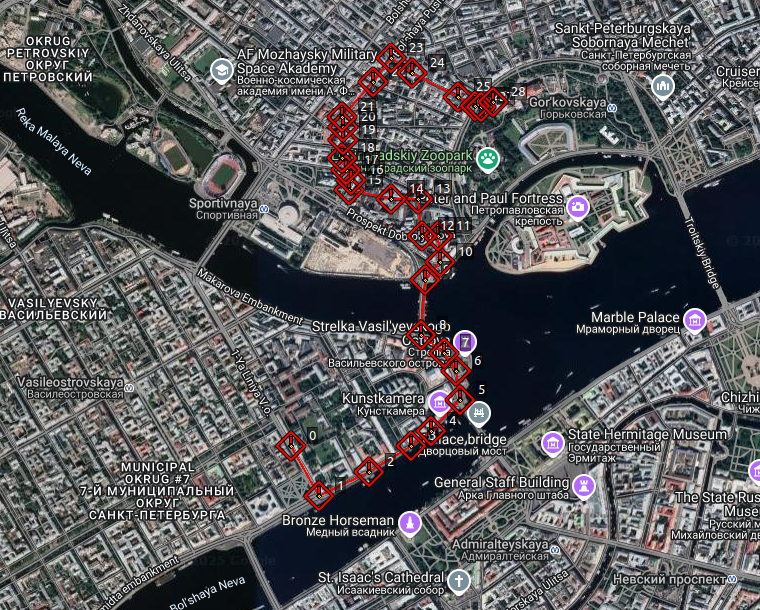

In [ ]:
wpl_file_content =  """QGC WPL 110
0	1	0	16	0	5	0	0	59.9403529909519506	30.29205322265625	0	1
1	0	3	16	0	5	0	0	59.9381925372565902	30.294424295425415	20	1
2	0	3	16	0	5	0	0	59.939240536105487	30.2987158298492432	20	1
3	0	3	16	0	5	0	0	59.9403543344738807	30.3023260831832886	20	1
4	0	3	16	0	5	0	0	59.9410005622152511	30.3040534257888794	20	1
5	0	3	16	0	5	0	0	59.9423494044888514	30.3065210580825806	20	1
6	0	3	16	0	5	0	0	59.9435692265450797	30.3061884641647339	20	1
7	0	3	16	0	5	0	0	59.9443430111053317	30.3051531314849854	20	1
8	0	3	16	0	5	0	0	59.9451382708626994	30.3032380342483521	20	1
9	0	3	16	0	5	0	0	59.9474943845763022	30.3035867214202881	20	1
10	0	3	16	0	5	0	0	59.9482613615205793	30.3048580884933472	20	1
11	0	3	16	0	5	0	0	59.9493667979443075	30.3046810626983643	20	1
12	0	3	16	0	5	0	0	59.9493882884450784	30.3032916784286499	20	1
13	0	3	16	0	5	0	0	59.9509597435527581	30.3029483556747437	20	1
14	0	3	16	0	5	0	0	59.9509919777495313	30.3006255626678467	20	1
15	0	3	16	0	5	0	0	59.9513358072311959	30.2969911694526672	20	1
16	0	3	16	0	5	0	0	59.9517696182459332	30.2972325682640076	20	1
17	0	3	16	0	5	0	0	59.9521980514151664	30.2967765927314758	20	1
18	0	3	16	0	5	0	0	59.9527124325121434	30.2964064478874207	20	1
19	0	3	16	0	5	0	0	59.9535061485151743	30.2965271472930908	20	1
20	0	3	16	0	5	0	0	59.9540581123975969	30.2965539693832397	20	1
21	0	3	16	0	5	0	0	59.954486515984442	30.2964413166046143	20	1
22	0	3	16	0	5	0	0	59.9559838705952473	30.2990537881851196	20	1
23	0	3	16	0	5	0	0	59.9570326499912269	30.3006201982498169	20	1
24	0	3	16	0	5	0	0	59.9563974777012447	30.3024628758430481	20	1
25	0	3	16	0	5	0	0	59.9553594215153254	30.3064057230949402	20	1
26	0	3	16	0	5	0	0	59.9549538590360171	30.3078407049179077	20	1
27	0	3	16	0	5	0	0	59.9549202857606502	30.3083878755569458	20	1
28	0	3	16	0	5	0	0	59.9551579838181681	30.3093641996383667	20	1
"""


Для выполнения задания в блоке ниже  
1. замените имя файла с маршрутом (на свой), вот эту строку:
   ```python
   wpl_file = "module2.wpl"
   ```
2. измените список скоростных ограничений, вот этот массив:
   ```python
   speed_limits = [
    GeoSpecificSpeedLimit(...
    ```
   
Учтите, что вам нужно доставить груз как можно быстрее, но при этом не нарушить правила дорожного движения. 

Ограничения скорости
- населённый пункт - 60 км/ч
- пешеходная зона - 20 км/ч
- магистраль - 110 км/ч

Составьте маршрут доставки так, чтобы машинка доехала за минимальное время. Для определения оптимального маршрута допустимо пользоваться сторонними сервисами (например, Яндекс картами).

In [1]:
# создадим wpl файл и запишем туда маршрутное задание
wpl_file = "module2.wpl"

**Примечание**:
После создания собственного маршрута удалите перезапись содержимого, чтобы не потерять свои наработки!


In [2]:
with open(wpl_file, "w") as f:
    f.write(wpl_file_content)

NameError: name 'wpl_file_content' is not defined

**Напоминание**: не забудьте изменить скоростные ограничения (speed_limits) при задании маршрутного задания!

In [ ]:
from src.wpl_parser import WPLParser

parser = WPLParser(wpl_file)    
points = parser.parse()
print(points)

from src.mission_type import GeoSpecificSpeedLimit
speed_limits = [
    GeoSpecificSpeedLimit(0, 60),
    GeoSpecificSpeedLimit(27, 20)
]

from src.mission_planner import Mission

home = points[0]
mission = Mission(home=home, waypoints=points,speed_limits=speed_limits, armed=True)

[Point(59.94035299095195, 30.29205322265625, 0.0), Point(59.93819253725659, 30.294424295425415, 0.0), Point(59.93924053610549, 30.298715829849243, 0.0), Point(59.94035433447388, 30.30232608318329, 0.0), Point(59.94100056221525, 30.30405342578888, 0.0), Point(59.94234940448885, 30.30652105808258, 0.0), Point(59.94356922654508, 30.306188464164734, 0.0), Point(59.94434301110533, 30.305153131484985, 0.0), Point(59.9451382708627, 30.303238034248352, 0.0), Point(59.9474943845763, 30.303586721420288, 0.0), Point(59.94826136152058, 30.304858088493347, 0.0), Point(59.94936679794431, 30.304681062698364, 0.0), Point(59.94938828844508, 30.30329167842865, 0.0), Point(59.95095974355276, 30.302948355674744, 0.0), Point(59.95099197774953, 30.300625562667847, 0.0), Point(59.951335807231196, 30.296991169452667, 0.0), Point(59.95176961824593, 30.297232568264008, 0.0), Point(59.952198051415166, 30.296776592731476, 0.0), Point(59.95271243251214, 30.29640644788742, 0.0), Point(59.953506148515174, 30.2965271

Запускаем симуляцию с новым маршрутным заданием

In [ ]:
from time import sleep
from geopy import Point as GeoPoint


from src.queues_dir import QueuesDirectory
from src.servos import Servos
from src.sitl import SITL
from src.cargo_bay import CargoBay
from src.mission_planner import MissionPlanner
from src.config import LOG_ERROR, LOG_INFO
from src.mission_planner_mqtt import MissionSender
from src.sitl_mqtt import TelemetrySender
from src.system_wrapper import SystemComponentsContainer


# координата текущего положения машинки
home = GeoPoint(latitude=59.9403529909519506, longitude=30.29205322265625) 


# каталог очередей для передачи сообщений между блоками
queues_dir = QueuesDirectory() 

if afcs_present:
    mission_sender = MissionSender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)
    telemetry_sender = TelemetrySender(
        queues_dir=queues_dir, client_id=car_id, log_level=LOG_ERROR)

mission_planner = MissionPlanner(
    queues_dir, afcs_present=afcs_present, mission=mission)

sitl = SITL(
    queues_dir=queues_dir, position=home,
    car_id=car_id, post_telemetry=afcs_present, log_level=LOG_ERROR)


communication_gateway = CommunicationGateway(
    queues_dir=queues_dir, log_level=LOG_ERROR)
control_system = ControlSystem(queues_dir=queues_dir, log_level=LOG_INFO)

navigation_system = NavigationSystem(
    queues_dir=queues_dir, log_level=LOG_ERROR)

servos = Servos(queues_dir=queues_dir, log_level=LOG_ERROR)
cargo_bay = CargoBay(queues_dir=queues_dir, log_level=LOG_INFO)

# у нас получилось довольно много блоков, используем класс SystemComponentsContainer
# для упрощения рутинной работы с ними - таким образом мы собираем все блоки машинки в одном "кузове"
system_components = SystemComponentsContainer(
    components=[
        mission_sender,
        telemetry_sender,
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system
    ] if afcs_present else [
        sitl,
        mission_planner,
        navigation_system,
        servos,
        cargo_bay,
        communication_gateway,
        control_system
    ])

system_components.start()

# ограничение поездки по времени
# параметр sleep - время в секундах,
# настройте этот параметр так, чтобы ваша машинка завершила маршрут
# в случае превышения времени выполнения ячейки на более чем 10 секунд от заданного, 
# допустимо перезапустить вычислительное ядро и повторно выполнить весь блокнот, штрафные очки за это не начисляются
# при условии, что повторный запуск закончился успешно
sleep(260)

# останавливаем все компоненты
system_components.stop()

# удалим все созданные компоненты
system_components.clean()

[ИНФО][QUEUES] создан каталог очередей
[ИНФО][QUEUES] регистрируем очередь planner.mqtt
[ИНФО][QUEUES] регистрируем очередь sitl.mqtt
[ИНФО][QUEUES] регистрируем очередь planner
[ИНФО][MISSION PLANNER] создана система планирования заданий
[ИНФО][QUEUES] регистрируем очередь sitl
[ИНФО][QUEUES] регистрируем очередь communication
[ИНФО][QUEUES] регистрируем очередь control
[ИНФО][CONTROL] создана система управления
[ИНФО][QUEUES] регистрируем очередь navigation
[ИНФО][QUEUES] регистрируем очередь servos
[ИНФО][QUEUES] регистрируем очередь cargo
[ИНФО][CARGO] создан компонент грузового отсека, отсек заблокирован
[ИНФО][MISSION PLANNER] старт системы планирования заданий
[ИНФО][CARGO] старт блока грузового отсека
[ИНФО][CONTROL] старт системы управления
[ИНФО][MISSION PLANNER] запрошена новая задача, отправляем получателям
[ИНФО][MISSION PLANNER] новая задача отправлена в коммуникационный шлюз
[ИНФО][CONTROL] установлена новая задача, начинаем следовать по маршруту, текущее время 17:12:35.

Process ControlSystem-123:
Process NavigationSystem-124:
Process CargoBay-126:
Process TelemetrySender-119:
Process CommunicationGateway-122:
Process MissionPlanner-120:
Process SITL-121:
Traceback (most recent call last):
Process MissionSender-118:
Process Servos-125:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/navig

KeyboardInterrupt: 

  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/communication_gateway.py", line 108, in run
    sleep(self._recalc_interval_sec)
Traceback (most recent call last):
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/mission_planner.py", line 180, in run
    sleep(self._recalc_interval_sec)
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/servos.py", line 141, in run
    sleep(self._recalc_interval_sec)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()


KeyboardInterrupt
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/cargo_bay.py", line 110, in run
    sleep(self._recalc_interval_sec)
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/mission_planner_mqtt.py", line 160, in run
    sleep(self._recalc_interval_sec)
KeyboardInterrupt
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/control_system.py", line 268, in run
    sleep(self._recalc_interval_sec)
KeyboardInterrupt
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/sitl.py", line 186, in run
    sleep(self._recalc_interval_sec)
Traceback (most recent call last):
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/artem/Dev/Python/cyberimmune-autonomy--chvt-preview/src/sitl_mqtt.py", line 162, in run
    sleep(self._recalc_interval_sec)
KeyboardInterrupt
KeyboardInterrupt


На этом модуль 2 завершён, надеемся, у вас всё получилось! 
На что можно ещё обратить вниманием - можно ли как-то улучшить маршрут для ускорения доставки? (без нарушения ПДД) - например, использовать более скоростные трассы или срезать какие-то участки.

Если идей быстрых улучшений нет, то пришло время перейти к самому интересному модулю и познакомиться с киберпрепятствиями!

Для работы над модулем 3 задания откройте блокнот cyberimmunity--autonomous-car-m3.